In [1]:
# -*- coding: utf-8 -*-
#https://matplotlib.org/stable/gallery/statistics/confidence_ellipse.html#sphx-glr-gallery-statistics-confidence-ellipse-py

#import esda
import pandas as pd
import geopandas as gpd
from geopandas import GeoDataFrame
#import libpysal as lps
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point
#import contextily as ctx
from pylab import figure, scatter, show
import warnings
# warnings.filterwarnings('ignore')
# %matplotlib inline
from math import cos
import seaborn as sns
import cartopy.crs as ccrs

import geoplot as gplt
import geoplot.crs as gcrs
from matplotlib.patches import Patch
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import math
from matplotlib.patches import Ellipse,Circle

In [2]:
def center(points):
    '''
    calculate the average position of the points
    '''
    x_mean = points.x.mean()
    y_mean = points.y.mean()
    return (x_mean,y_mean)

def angle(points,center):
    '''
    calculate the angle of Ellipse, clockwise
    '''
    x = points.x-center[0]
    y = points.y-center[1]
    A = sum(x*x)-sum(y*y)
    B = math.sqrt(A*A+4*sum(x*y)*sum(x*y))
    C = 2*sum(x*y)
    theta = np.arctan((A+B)/C)
    #theta = 180*theta/np.pi
    return theta

def xy_sigma(points,center,theta):
    '''
    calculate the x,y length by one standard deviation
    '''
    x = points.x-center[0]
    y = points.y-center[1]
    x1 = x*np.cos(theta)-y*np.sin(theta)
    y1 = x*np.sin(theta)+y*np.cos(theta)
    x_sigma = math.sqrt(2*sum(x1*x1)/x.count())
    y_sigma = math.sqrt(2*sum(y1*y1)/x.count())
    if(x_sigma>=y_sigma):
        return(x_sigma,y_sigma)
    else:
        return(y_sigma,x_sigma)

In [4]:
r_labels = ['All retails','Comprehensive','Food, beverages and tobacco products','Textiles, apparel and daily necessities',
           'Cultural, sporting goods and equipment','medicines and medical equipment','automobiles, motorcycles, spare parts and fuel and other power',
           'household appliances and electronic products','hardware, furniture and upholstery materials']
year = 2020 
scattergdf = gpd.read_file(f'../result/data/osm_poi_data_selected/{year}/greater-london-{year}-free-selected.shp')
scattergdf = scattergdf.to_crs(crs='OSGB36 / British National Grid + ODN height') 
#scattergdf
df_map = gpd.read_file('../data/statistical-gis-boundaries-london/ESRI/', crs='ESRI:54004')

In [5]:
# Standard Deviational Ellipse
# Reference: https://blog.51cto.com/u_15707947/5445009
# 1. calculate the mean position
p_mean = center(scattergdf.geometry)
# 2. calculate the angle
theta = angle(scattergdf.geometry,p_mean)
# 3. calculate the x,y length
x_sigma,y_sigma = xy_sigma(scattergdf.geometry,p_mean,theta)

theta = 90 - 180*theta/np.pi  #clockwise to anticlockwise

p_means = [p_mean]
thetas = [theta]
x_sigmas = [x_sigma]
y_sigmas = [y_sigma]

for i in range(1,int(scattergdf['class'].max())+1):
    
    temp = scattergdf[scattergdf['class']==i]
    # 1. calculate the mean position
    p_mean = center(temp.geometry)
    # 2. calculate the angle
    theta = angle(temp.geometry,p_mean)
    # 3. calculate the x,y length
    x_sigma,y_sigma = xy_sigma(temp.geometry,p_mean,theta)
    
    theta = 90 - 180*theta/np.pi  #clockwise to anticlockwise
    
    p_means.append(p_mean)
    thetas.append(theta)
    x_sigmas.append(x_sigma)
    y_sigmas.append(y_sigma)


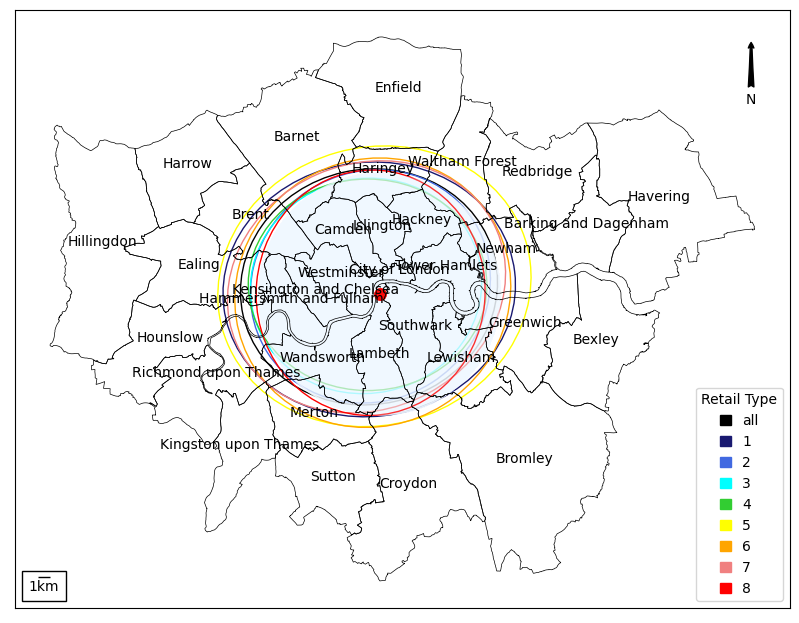

In [7]:
from shapely import geometry
color = ['black','midnightblue','royalblue','cyan','limegreen','yellow','orange','lightcoral','red']
labels = ['all','1','2','3','4','5','6','7','8']
# draw the london map 

fig,ax = plt.subplots(figsize=(10,10))
# draw the boroughs of London

df_map.plot(ax=ax,facecolor='none',edgecolor='k',lw=0.5,zorder=12)


centroids = df_map.geometry.centroid
#ax.text(centroids.x,centroids.y,s = df_map['NAME'])
for i,p in enumerate(centroids):
    ax.text(p.x,p.y,s = df_map.loc[i,'NAME'],fontsize=10,color='k',zorder=13,
            horizontalalignment='center')
    
nT = int(scattergdf['class'].max())
for i in range(0,nT+1):

    # draw 8 types of retail shops 
    if i==0:
        data = scattergdf
    else:
        data = scattergdf[scattergdf['class']==i]
    
    # data.plot(ax=ax,color=color[i],marker='o',
    #           markersize=0.5,alpha=0.6)
    
    p_mean = p_means[i]
    theta  = thetas[i]
    x_sigma = x_sigmas[i]
    y_sigma = y_sigmas[i]
    
    width,height = x_sigma,y_sigma
    e = Ellipse(xy = p_mean, width = width * 2, height = height * 2, angle=theta,
            facecolor='none',edgecolor=color[i])
    ax.add_artist(e)
    size = 1000 
    cen = gpd.GeoSeries([geometry.Point(-0.115958, 51.50021),],
              index=['a'],crs='EPSG:4326')
    cen  = cen.to_crs(crs='OSGB36 / British National Grid + ODN height')

    cir = Circle(xy=(cen.geometry.x,cen.geometry.y),radius=size*10,alpha=0.2,color='aliceblue')
    ax.add_patch(cir)
    ax.plot(cen.geometry.x,cen.geometry.y,'ro',markersize=8,alpha=0.3)
    
#ax.axis('on')
plt.xticks([])
plt.yticks([])

#plot North arrow
x,y,arrow_length = 0.95,0.95,0.1
ax.annotate('N',xy=(x,y),xytext=(x,y-arrow_length),
            ha = 'center',va='center',fontsize=10,
            arrowprops=dict(arrowstyle='Fancy',facecolor='black'),
            xycoords=ax.transAxes)

#plot scale bar
size = 1000  # distance
iow_scale_bar = AnchoredSizeBar(ax.transData,
                                size=size,label='1km',loc='lower left',pad=0.5,
                                borderpad=0.5,color='black',
                                frameon=True)#,size_vertical=0.5)
ax.add_artist(iow_scale_bar)

#plot legend

legend_elements = [Patch(facecolor=color[i], edgecolor=color[i],
                      label=labels[i]) for i in range(0,nT+1)]

ax.legend(handles=legend_elements, loc='lower right',handlelength=0.8,fontsize=10,title='Retail Type')
    
path_out = '../result/plot/'
filename = f'{year}_StandardDeviationEllipse'
plt.savefig(path_out+filename+'.png',
                dpi=500,bbox_inches = 'tight')

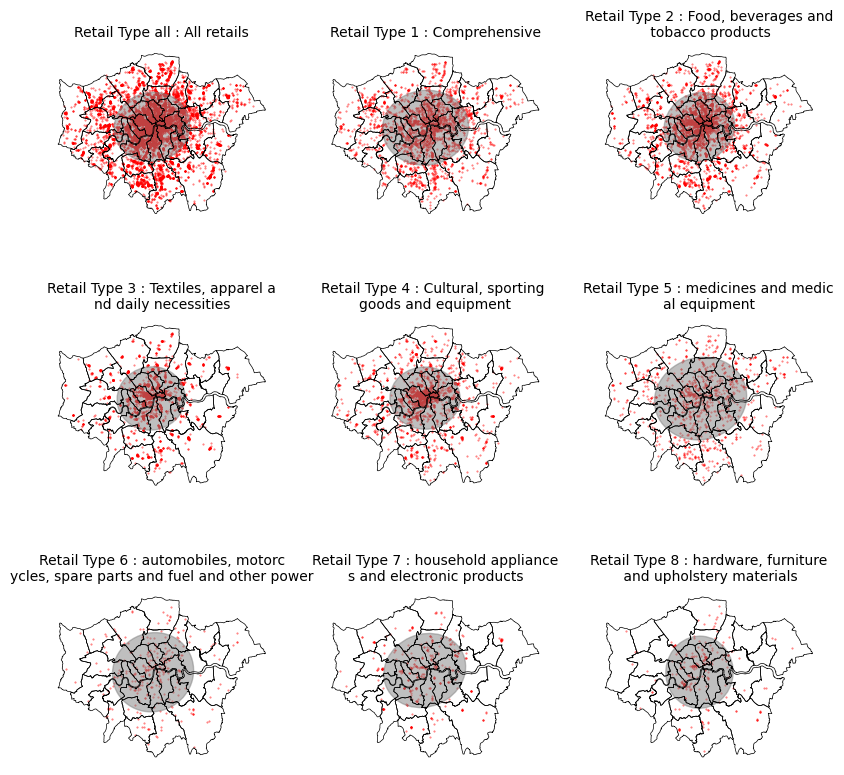

In [8]:
fig,axs = plt.subplots(3, 3,figsize=(10,10))

nT = int(scattergdf['class'].max())
for i in range(0,nT+1):
    ii = (i)//3
    jj = (i)%3
    if i==0:
        data = scattergdf
    else:
        data = scattergdf[scattergdf['class']==i]
    
    data.plot(ax=axs[ii,jj],color='red',marker='o',
              markersize=0.2,alpha=0.6)
    # draw the boroughs of London
    df_map.plot(ax=axs[ii,jj],facecolor='none',edgecolor='k',lw=0.5,zorder=12)
   
    p_mean = p_means[i]
    theta  = thetas[i]
    x_sigma = x_sigmas[i]
    y_sigma = y_sigmas[i]
    
    width,height = x_sigma,y_sigma
    #print(width,height)
    e = Ellipse(xy = p_mean, width = width * 2, height = height * 2, angle=theta,
            facecolor='gray',edgecolor='gray',alpha=0.5)
    axs[ii,jj].add_artist(e)  
    
    title = f'Retail Type {labels[i]} : {r_labels[i]}'
    if(len(title)>35):
        title=title[0:35]+'\n'+title[35:]
    axs[ii,jj].set_title(title,fontsize=10)
    axs[ii,jj].axis('off')
    #plt.xticks([])
    #plt.yticks([])
       
#axs[2,2].axis('off')
#plot legend  
#legend_elements = [Patch(facecolor=color[i], edgecolor=color[i],
#                      label=labels[i]) for i in range(0,nT+1)]    
#plt.legend(handles=legend_elements, loc='lower right',handlelength=0.8,fontsize=10,title='Retail Type')
    
path_out = '../result/plot/'
filename = f'{year}_all_SDE'
plt.savefig(path_out+filename+'.png',
                dpi=500,bbox_inches = 'tight')